# LSTM model 

We trained the LSTM model on the data of cluster 1 (with x coordinate 8678). Input sequence of density for 60 timesteps is given as input to the model and prediction of the density at 5th sec is made.

In [1]:
import numpy as np

import random

import matplotlib.pyplot as plt

import pandas as pd

from collections import deque

import time
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

#from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
import math

from tensorflow.keras.models import load_model

def compare(Mat1,Mat2,per1,per2):

    total = len(Mat1)  # get the times

    num1 = int((per1/100)*total)

    num2 = int((per2/100)*total)

    plt.plot(range(num2-num1),Mat1[num1:num2],label="Prediction")

    plt.plot(range(num2-num1),Mat2[num1:num2],label="Actual")

    plt.legend()

    plt.show()


# below functions are used to preprocess data and to make it
# feasible so as to give it as input to the LSTM model
    
    
def preprocess_df(df):

    df.dropna(inplace=True)  

    return df




def preprocess_df_final(df):

    sequential_data = []  

    prev_days = deque(maxlen=SEQ_LEN) 
    

    for i in df.values:  

        prev_days.append(i[1])  

        if len(prev_days) == SEQ_LEN:  
            sequential_data.append([i[0],np.array(prev_days), i[-1]])  
    random.shuffle(sequential_data) 

    X = []

    y = []
     

    for time , seq, target in sequential_data:  
        X.append(seq)  
        y.append(target)  

    X=np.array(X)

    X=X.reshape((X.shape[0],X.shape[1],1))

    return X, y

Here attributes of the model are defined. (sequence length of 60 and prediction of the 5th sec)

In [16]:
MODEL =5
SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 5
EPOCHS = 10
SCALE = 1
BATCH_SIZE = 64
NAME = f"NEW-{MODEL}-MODEL-{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{SCALE}-SCALE-128-64-32-32-8-1-{int(time.time())}"
index=["Time","Density"]
scaler = MinMaxScaler(feature_range=(0, 1))

main_df = pd.read_csv("df_8678.csv") 

main_df = main_df[['Timestep','Density']]

Scaling the input feature

In [17]:
main_df.columns=index

a1=np.array(main_df)

if SCALE==1:

    main_df["Density"] = scaler.fit_transform(main_df[["Density"]])

    
main_df

,Time,Density
0,0,0.016393
1,1,0.016393
2,2,0.016393
3,3,0.016393
4,4,0.016393
...,...,...
26219,26219,0.000000
26220,26220,0.000000
26221,26221,0.000000
26222,26222,0.000000


Shift the density value to get the actual value of density after 5 seconds

In [18]:
main_df=preprocess_df(main_df)
main_df['future'] = main_df["Density"].shift(-FUTURE_PERIOD_PREDICT)



In [19]:
times = sorted(main_df.index.values)  

len(times)

26224

Divide the data into train and validation

In [20]:
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]  

last_5pct

24913

In [21]:
validation_main_df = main_df[(main_df.index >= last_5pct)]  

main_df = main_df[(main_df.index < last_5pct)] 



In [22]:
validation_main_df.dropna(inplace=True)



/home/sahil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
train_x, train_y = preprocess_df_final(main_df)

validation_x, validation_y = preprocess_df_final(validation_main_df)




In [24]:
validation_x

array([[[0.06557377],
        [0.06557377],
        [0.06557377],
        ...,
        [0.03278689],
        [0.03278689],
        [0.03278689]],

       [[0.52459016],
        [0.50819672],
        [0.49180328],
        ...,
        [0.42622951],
        [0.42622951],
        [0.44262295]],

       [[0.03278689],
        [0.03278689],
        [0.03278689],
        ...,
        [0.01639344],
        [0.01639344],
        [0.01639344]],

       ...,

       [[0.01639344],
        [0.01639344],
        [0.01639344],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [25]:
print(f"train data: {len(train_x)} validation: {len(validation_x)}")

train data: 24854 validation: 1247


LSTM model is defined here with hidden layers and other parameters

LSTM architecture is as below

In [26]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())  
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32, activation='tanh'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.summary()
opt = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
model.compile(
    loss='mse',
    optimizer="adam",
    metrics=['mse', 'mae', 'mape','acc']
    )
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"+NAME  # unique file name that will include the epoch and the validation acc for that epoch
#checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 128)           512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 64)            49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 60, 64)            256       
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)               

Training the model and saving it

In [27]:
from numpy import asarray

history = model.fit(
asarray(train_x), asarray(train_y),
batch_size=BATCH_SIZE,
epochs=EPOCHS,
validation_data=(asarray(validation_x), asarray(validation_y)),
callbacks=[tensorboard]
)
score = model.evaluate(asarray(validation_x), asarray(validation_y), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save("models/{}".format(NAME))

Train on 24854 samples, validate on 1247 samples
Epoch 1/10
24854/24854 [==============================] - 53s 2ms/sample - loss: 0.0413 - mse: 0.0413 - mae: 0.1188 - mape: 20.7231 - acc: 8.0470e-05 - val_loss: 0.2301 - val_mse: 0.2301 - val_mae: 0.4589 - val_mape: 236369872.0000 - val_acc: 0.0000e+00
Epoch 2/10
24854/24854 [==============================] - 53s 2ms/sample - loss: 0.0049 - mse: 0.0049 - mae: 0.0546 - mape: 9.6202 - acc: 8.0470e-05 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1726 - val_mape: 91500344.0000 - val_acc: 0.4362
Epoch 3/10
24854/24854 [==============================] - 52s 2ms/sample - loss: 0.0038 - mse: 0.0038 - mae: 0.0484 - mape: 8.5230 - acc: 8.0470e-05 - val_loss: 0.0310 - val_mse: 0.0310 - val_mae: 0.1681 - val_mape: 89107616.0000 - val_acc: 0.4362
Epoch 4/10
24854/24854 [==============================] - 50s 2ms/sample - loss: 0.0032 - mse: 0.0032 - mae: 0.0449 - mape: 7.8676 - acc: 8.0470e-05 - val_loss: 0.0330 - val_mse: 0.0330 - val_mae: 0.16

Predicting the density value for various sequence of 
density values from the test set.

Graphs shows the variation of density in predicted and actual values.

1247/1247 [==============================] - 1s 855us/sample
Train Score: 2.35 RMSE
Test Score: 6.96 RMSE


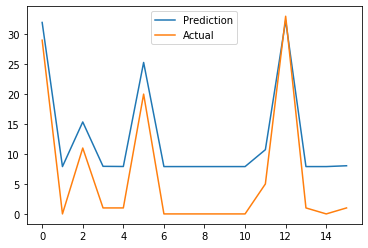

In [28]:
trainPredict = model.predict(train_x,verbose=1)

testPredict = model.predict(validation_x,verbose=1)

trainPredict = scaler.inverse_transform(trainPredict)

trainY = scaler.inverse_transform([train_y])

testPredict = scaler.inverse_transform(testPredict)

testY = scaler.inverse_transform([validation_y])

 

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Test Score: %.2f RMSE' % (testScore))



compare(testPredict,testY.transpose(),90,91.3)

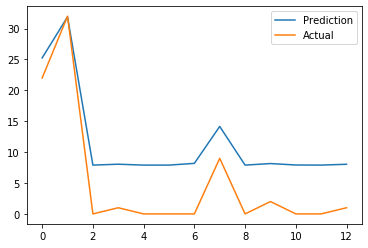

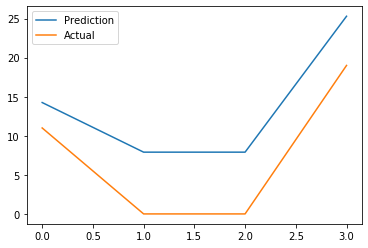

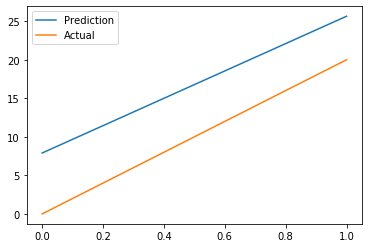

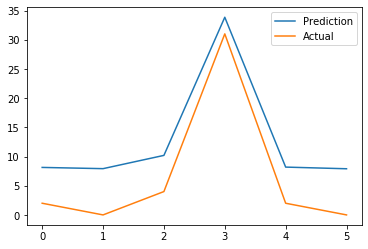

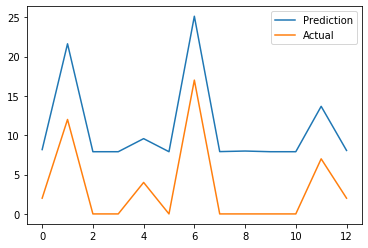

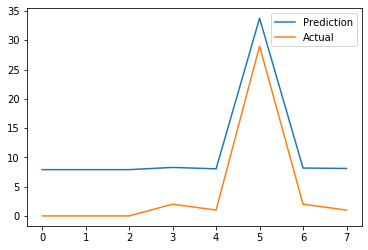

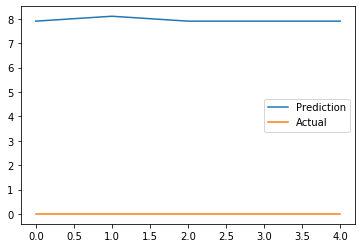

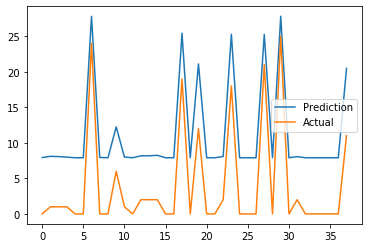

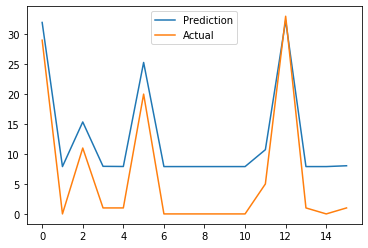

In [29]:
compare(testPredict,testY.transpose(),10,11)

compare(testPredict,testY.transpose(),18,18.3)

compare(testPredict,testY.transpose(),30,30.2)

compare(testPredict,testY.transpose(),42,42.5)

compare(testPredict,testY.transpose(),53,54)

compare(testPredict,testY.transpose(),60.7,61.3)

compare(testPredict,testY.transpose(),70.9,71.3)

compare(testPredict,testY.transpose(),80,83)

compare(testPredict,testY.transpose(),90,91.3)

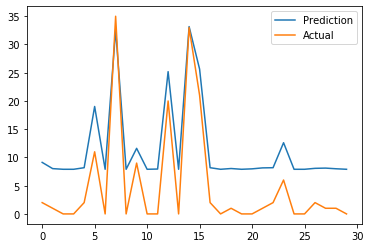

In [32]:
compare(testPredict,testY.transpose(),47.6,50)

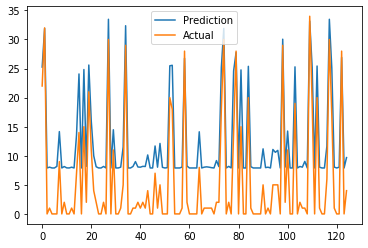

In [36]:
compare(testPredict,testY.transpose(),10,20)